# Virtual Fields Method

### Case Study: Unnotched Iosipescu Test for Orthotropic Material

**Based on:**
*“The Virtual Fields Method: Extracting Constitutive Mechanical Parameters from Full-Field Deformation Measurements”*
by F. Pierron and M. Grédiac

**Developed by:**
José Xavier
Universidade NOVA de Lisboa, NOVA FCT, UNIDEMI
[https://userweb.fct.unl.pt/~jmc.xavier/](https://userweb.fct.unl.pt/~jmc.xavier/)

## Course Context

This notebook is part of the **CISM Advanced School**
**“Image-Based Mechanics: An Overview of Experimental and Numerical Approaches”**
Udine, Italy — *6–10 October 2025*

**Coordinators:** Julien Réthoré and José Xavier

**Lecture Topic:**
*“The Virtual Fields Method: Extracting Material Parameters from Heterogeneous Fields — Hands-On Session”*

For more information:
[https://cism.it/en/activities/courses/C2516/](https://cism.it/en/activities/courses/C2516/)

---
## Introduction

This notebook performs noise sensitivity analysis for the Virtual Fields Method applied to orthotropic material identification. The analysis uses Monte Carlo simulation with Gaussian white noise to evaluate the robustness of the three virtual field sets.

**Analysis Features:**
- Gaussian white noise addition to strain fields
- Monte Carlo simulation with 30 iterations
- Statistical analysis: mean, standard deviation, coefficient of variation
- Comparison of noise robustness between virtual field sets
- Histogram visualization of parameter distributions

In [21]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from scipy import io
from io import StringIO

# Set plotting parameters
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (15, 12)

## 1. Noise Model

### Gaussian White Noise

Noise is added to strain measurements as:

$$
\varepsilon_{noisy} = \varepsilon_{clean} + \mathcal{N}(0, \sigma^2)
$$

where:
- $\mathcal{N}(0, \sigma^2)$ is Gaussian noise with zero mean and standard deviation $\sigma$
- Default: $\sigma = 10^{-4}$ (typical DIC measurement noise level)

### Statistical Metrics

For each parameter, we compute:

**Coefficient of Variation (CV):**
$$
CV = \frac{\sigma_{param}}{\mu_{param}} \times 100\%
$$

**Relative Error:**
$$
Error = \frac{|\mu_{param} - Q_{ref}|}{Q_{ref}} \times 100\%
$$

## 2. Complete Noise Analysis Implementation

Copy the complete `IosipescuVFMNoise` class from your `Iosipescu_orthotropic_VFM_noise.py` file

In [22]:

class IosipescuVFMNoise:
    """
    VFM analysis with noise simulation adapted for current data structure
    """

    def __init__(self, data_source='csv'):
        self.data_source = data_source
        self.data = {}
        self.results = {}
        self.noise_results = {}

    # def load_data_from_csv(self, csv_dir='.'):
    #     """Load data using the same structure as the working VFM code"""
    #     # Load scalar parameters from scalarsFE.csv
    #     scalar_path = os.path.join(csv_dir, 'scalarsFE.csv')
    #
    #     if os.path.exists(scalar_path):
    #         with open(scalar_path, 'r') as f:
    #             for line in f:
    #                 if '=' in line:
    #                     key, value = line.strip().split('=')
    #                     key = key.strip()
    #                     value = float(value.strip())
    #
    #                     # Map the scalar parameters
    #                     if key == 'Length':
    #                         self.data['L'] = value
    #                     elif key == 'Width':
    #                         self.data['w'] = value
    #                     elif key == 'Thick':
    #                         self.data['t'] = value
    #                     elif key == 'P':
    #                         self.data['F'] = value
    #
    #     # Load FEM data from FEM2VFM.csv
    #     fem_path = os.path.join(csv_dir, 'FEM2VFM.csv')
    #
    #     if os.path.exists(fem_path):
    #         # Read the space-delimited file
    #         fem_data = pd.read_csv(fem_path, sep=r'\s+')
    #
    #         # Map the field data
    #         self.data['X1'] = fem_data['X_Coord'].values
    #         self.data['X2'] = fem_data['Y_Coord'].values
    #         self.data['Eps1'] = fem_data['Eps_X'].values
    #         self.data['Eps2'] = fem_data['Eps_Y'].values
    #         self.data['Eps6'] = fem_data['Eps_XY'].values
    #
    #     # Validate data
    #     self._validate_data()

    def load_data_from_csv(self, csv_dir='.'):
        """Load data from CSV files (local or URL)"""

        # Determine if we're working with URL or local path
        is_url = csv_dir.startswith('http')

        # Construct paths
        if is_url:
            base = csv_dir.rstrip('/')
            scalar_path = f"{base}/scalarsFE.csv"
            fem_path = f"{base}/FEM2VFM.csv"
        else:
            scalar_path = os.path.join(csv_dir, 'scalarsFE.csv')
            fem_path = os.path.join(csv_dir, 'FEM2VFM.csv')

        # Load scalar parameters
        try:
            if is_url:
                response = requests.get(scalar_path)
                response.raise_for_status()
                content = response.text
            else:
                with open(scalar_path, 'r') as f:
                    content = f.read()

            for line in content.split('\n'):
                if '=' in line:
                    key, value = line.strip().split('=')
                    key = key.strip()
                    value = float(value.strip())

                    if key == 'Length':
                        self.data['L'] = value
                    elif key == 'Width':
                        self.data['w'] = value
                    elif key == 'Thick':
                        self.data['t'] = value
                    elif key == 'P':
                        self.data['F'] = value

            print(f"Loaded scalars from: {scalar_path}")
        except Exception as e:
            print(f"Error loading {scalar_path}: {e}")
            raise

        # Load FEM data
        try:
            fem_data = pd.read_csv(fem_path, sep=r'\s+')

            self.data['X1'] = fem_data['X_Coord'].values
            self.data['X2'] = fem_data['Y_Coord'].values
            self.data['Eps1'] = fem_data['Eps_X'].values
            self.data['Eps2'] = fem_data['Eps_Y'].values
            self.data['Eps6'] = fem_data['Eps_XY'].values

            print(f"Loaded FEM data from: {fem_path}")
        except Exception as e:
            print(f"Error loading {fem_path}: {e}")
            raise

    def _validate_data(self):
        """Validate loaded data"""
        print("Data validation:")
        for key, value in self.data.items():
            if np.isscalar(value):
                print(f"  {key}: {value}")
            else:
                arr = np.array(value)
                print(f"  {key}: shape {arr.shape}, range [{arr.min():.3f}, {arr.max():.3f}]")

        # Check coordinate ranges
        X1, X2 = self.data['X1'], self.data['X2']
        L, w = self.data['L'], self.data['w']
        print(f"\nCoordinate validation:")
        print(f"  X1 range: [{X1.min():.3f}, {X1.max():.3f}], Expected: [0, {L}]")
        print(f"  X2 range: [{X2.min():.3f}, {X2.max():.3f}], Expected: [approx ±{w / 2}]")

    def load_data(self, source_path='.'):
        """Load data from specified path"""
        if self.data_source == 'csv':
            self.load_data_from_csv(source_path)
        else:
            raise ValueError("Only CSV loading implemented")

    def virtual_fields_set_1(self, Eps1, Eps2, Eps6):
        """First set of virtual fields - same as working code"""
        X1 = self.data['X1']
        X2 = self.data['X2']
        L = self.data['L']
        w = self.data['w']
        t = self.data['t']
        F = self.data['F']

        A = np.zeros((4, 4))
        B = np.zeros(4)

        # VF1: U1*=0, U2*=-x1 → ε1*=0, ε2*=0, ε6*=-1
        A[0, 0] = 0  # Q11 coefficient
        A[0, 1] = 0  # Q22 coefficient
        A[0, 2] = 0  # Q12 coefficient
        A[0, 3] = np.mean(Eps6)  # Q66 coefficient
        B[0] = F / (w * t)

        # VF2: U1*=x1(L-x1)x2, U2*=x1^3/3-Lx1^2/2 → ε1*=(L-2x1)x2, ε2*=0, ε6*=0
        vf2_eps1_star = (L - 2 * X1) * X2
        A[1, 0] = -np.mean(Eps1 * vf2_eps1_star)
        A[1, 1] = 0
        A[1, 2] = -np.mean(Eps2 * vf2_eps1_star)
        A[1, 3] = 0
        B[1] = F * L * L / (6 * w * t)

        # VF3: U1*=0, U2*=x1(L-x1)x2 → ε1*=0, ε2*=x1(L-x1), ε6*=(L-2x1)x2
        vf3_eps2_star = X1 * (L - X1)
        vf3_eps6_star = (L - 2 * X1) * X2
        A[2, 0] = 0
        A[2, 1] = -np.mean(Eps2 * vf3_eps2_star)
        A[2, 2] = -np.mean(Eps1 * vf3_eps2_star)
        A[2, 3] = -np.mean(Eps6 * vf3_eps6_star)
        B[2] = 0

        # VF4: U1*=L*sin(2πx1/L)/(2π), U2*=0 → ε1*=cos(2πx1/L), ε2*=0, ε6*=0
        vf4_eps1_star = np.cos(2 * np.pi * X1 / L)
        A[3, 0] = np.mean(Eps1 * vf4_eps1_star)
        A[3, 1] = 0
        A[3, 2] = np.mean(Eps2 * vf4_eps1_star)
        A[3, 3] = 0
        B[3] = 0

        # Solve system
        Q = np.linalg.solve(A, B)
        return Q

    def virtual_fields_set_2(self, Eps1, Eps2, Eps6):
        """Second set of virtual fields - same as working code"""
        X1 = self.data['X1']
        X2 = self.data['X2']
        L = self.data['L']
        w = self.data['w']
        t = self.data['t']
        F = self.data['F']

        A = np.zeros((4, 4))
        B = np.zeros(4)

        # VF1: U1*=0, U2*=-x1 → ε1*=0, ε2*=0, ε6*=-1
        A[0, 0] = 0
        A[0, 1] = 0
        A[0, 2] = 0
        A[0, 3] = np.mean(Eps6)
        B[0] = F / (w * t)

        # VF2: U1*=x1(L-x1)x2, U2*=x1^3/3-Lx1^2/2 → ε1*=(L-2x1)x2, ε2*=0, ε6*=0
        vf2_eps1_star = (L - 2 * X1) * X2
        A[1, 0] = -np.mean(Eps1 * vf2_eps1_star)
        A[1, 1] = 0
        A[1, 2] = -np.mean(Eps2 * vf2_eps1_star)
        A[1, 3] = 0
        B[1] = F * L * L / (6 * w * t)

        # VF3: U1*=0, U2*=x1(L-x1)x2 → ε1*=0, ε2*=x1(L-x1), ε6*=(L-2x1)x2
        vf3_eps2_star = X1 * (L - X1)
        vf3_eps6_star = (L - 2 * X1) * X2
        A[2, 0] = 0
        A[2, 1] = -np.mean(Eps2 * vf3_eps2_star)
        A[2, 2] = -np.mean(Eps1 * vf3_eps2_star)
        A[2, 3] = -np.mean(Eps6 * vf3_eps6_star)
        B[2] = 0

        # VF4: U1*=0, U2*=x1(L-x1)x2^3 → ε1*=0, ε2*=3x1(L-x1)x2^2, ε6*=(L-2x1)x2^3
        vf4_eps2_star = 3 * X1 * (L - X1) * X2 * X2
        vf4_eps6_star = (L - 2 * X1) * X2 * X2 * X2
        A[3, 0] = 0
        A[3, 1] = -np.mean(Eps2 * vf4_eps2_star)
        A[3, 2] = -np.mean(Eps1 * vf4_eps2_star)
        A[3, 3] = -np.mean(Eps6 * vf4_eps6_star)
        B[3] = 0

        # Solve system
        Q = np.linalg.solve(A, B)
        return Q

    def virtual_fields_set_3(self, Eps1, Eps2, Eps6):
        """Third set of virtual fields - same as working code"""
        X1 = self.data['X1']
        X2 = self.data['X2']
        L = self.data['L']
        w = self.data['w']
        t = self.data['t']
        F = self.data['F']

        A = np.zeros((4, 4))
        B = np.zeros(4)

        # VF1: U1*=0, U2*=-x1^3 → ε1*=0, ε2*=-3x1^2, ε6*=0
        A[0, 0] = 0
        A[0, 1] = 0
        A[0, 2] = 0
        A[0, 3] = 3 * np.mean(Eps6 * X1 * X1)
        B[0] = F * L * L / (w * t)

        # VF2: U1*=x1(L-x1)x2, U2*=x1^3/3-Lx1^2/2 → ε1*=(L-2x1)x2, ε2*=0, ε6*=0
        vf2_eps1_star = (L - 2 * X1) * X2
        A[1, 0] = -np.mean(Eps1 * vf2_eps1_star)
        A[1, 1] = 0
        A[1, 2] = -np.mean(Eps2 * vf2_eps1_star)
        A[1, 3] = 0
        B[1] = F * L * L / (6 * w * t)

        # VF3: U1*=0, U2*=x1(L-x1)x2 → ε1*=0, ε2*=x1(L-x1), ε6*=(L-2x1)x2
        vf3_eps2_star = X1 * (L - X1)
        vf3_eps6_star = (L - 2 * X1) * X2
        A[2, 0] = 0
        A[2, 1] = -np.mean(Eps2 * vf3_eps2_star)
        A[2, 2] = -np.mean(Eps1 * vf3_eps2_star)
        A[2, 3] = -np.mean(Eps6 * vf3_eps6_star)
        B[2] = 0

        # VF4: U1*=L*sin(2πx1/L)/(2π), U2*=0 → ε1*=cos(2πx1/L), ε2*=0, ε6*=0
        vf4_eps1_star = np.cos(2 * np.pi * X1 / L)
        A[3, 0] = np.mean(Eps1 * vf4_eps1_star)
        A[3, 1] = 0
        A[3, 2] = np.mean(Eps2 * vf4_eps1_star)
        A[3, 3] = 0
        B[3] = 0

        # Solve system
        Q = np.linalg.solve(A, B)
        return Q

    def run_noise_analysis(self, noise_amplitude=10e-4, n_iterations=30, Q_ref=None, material_name="reference"):
        """
        Run VFM analysis with white noise simulation over multiple iterations

        Parameters:
        noise_amplitude: Standard deviation of Gaussian white noise (default: 10e-4)
        n_iterations: Number of Monte Carlo iterations (default: 30)
        Q_ref: Reference values for comparison (GPa)
        material_name: Name of the material for reference
        """
        print("=" * 80)
        print("VFM NOISE ANALYSIS - WHITE NOISE SIMULATION")
        print("=" * 80)
        print(f"Noise amplitude (std dev): {noise_amplitude:.1e}")
        print(f"Number of iterations: {n_iterations}")
        print(f"Material: {material_name}")

        # Get original strain data
        Eps1_orig = self.data['Eps1']
        Eps2_orig = self.data['Eps2']
        Eps6_orig = self.data['Eps6']

        print(f"\nOriginal strain data shapes:")
        print(f"  Eps1: {Eps1_orig.shape}")
        print(f"  Eps2: {Eps2_orig.shape}")
        print(f"  Eps6: {Eps6_orig.shape}")

        # Initialize result arrays
        Q11_set1, Q22_set1, Q12_set1, Q66_set1 = [], [], [], []
        Q11_set2, Q22_set2, Q12_set2, Q66_set2 = [], [], [], []
        Q11_set3, Q22_set3, Q12_set3, Q66_set3 = [], [], [], []

        print(f"\nRunning {n_iterations} iterations with white noise...")
        successful_iterations = 0

        for i in range(n_iterations):
            if (i + 1) % 10 == 0 or i == 0:
                print(f"  Iteration {i + 1}/{n_iterations}")

            # Add Gaussian white noise to strain data
            noise1 = np.random.randn(*Eps1_orig.shape) * noise_amplitude
            noise2 = np.random.randn(*Eps2_orig.shape) * noise_amplitude
            noise6 = np.random.randn(*Eps6_orig.shape) * noise_amplitude

            Eps1_noisy = Eps1_orig + noise1
            Eps2_noisy = Eps2_orig + noise2
            Eps6_noisy = Eps6_orig + noise6

            # Run all three virtual field sets
            try:
                # Set 1
                Q1 = self.virtual_fields_set_1(Eps1_noisy, Eps2_noisy, Eps6_noisy)
                Q11_set1.append(Q1[0])
                Q22_set1.append(Q1[1])
                Q12_set1.append(Q1[2])
                Q66_set1.append(Q1[3])

                # Set 2
                Q2 = self.virtual_fields_set_2(Eps1_noisy, Eps2_noisy, Eps6_noisy)
                Q11_set2.append(Q2[0])
                Q22_set2.append(Q2[1])
                Q12_set2.append(Q2[2])
                Q66_set2.append(Q2[3])

                # Set 3
                Q3 = self.virtual_fields_set_3(Eps1_noisy, Eps2_noisy, Eps6_noisy)
                Q11_set3.append(Q3[0])
                Q22_set3.append(Q3[1])
                Q12_set3.append(Q3[2])
                Q66_set3.append(Q3[3])

                successful_iterations += 1

            except np.linalg.LinAlgError:
                print(f"    Warning: Singular matrix at iteration {i + 1}, skipping...")
                continue

        print(f"Completed {successful_iterations}/{n_iterations} successful iterations")

        # Convert to numpy arrays and to GPa
        Q11_set1 = np.array(Q11_set1) / 1e3
        Q22_set1 = np.array(Q22_set1) / 1e3
        Q12_set1 = np.array(Q12_set1) / 1e3
        Q66_set1 = np.array(Q66_set1) / 1e3

        Q11_set2 = np.array(Q11_set2) / 1e3
        Q22_set2 = np.array(Q22_set2) / 1e3
        Q12_set2 = np.array(Q12_set2) / 1e3
        Q66_set2 = np.array(Q66_set2) / 1e3

        Q11_set3 = np.array(Q11_set3) / 1e3
        Q22_set3 = np.array(Q22_set3) / 1e3
        Q12_set3 = np.array(Q12_set3) / 1e3
        Q66_set3 = np.array(Q66_set3) / 1e3

        # Store results
        self.noise_results = {
            'set1': {'Q11': Q11_set1, 'Q22': Q22_set1, 'Q12': Q12_set1, 'Q66': Q66_set1},
            'set2': {'Q11': Q11_set2, 'Q22': Q22_set2, 'Q12': Q12_set2, 'Q66': Q66_set2},
            'set3': {'Q11': Q11_set3, 'Q22': Q22_set3, 'Q12': Q12_set3, 'Q66': Q66_set3}
        }

        # Store the last iteration's noisy strain data for plotting
        self.Eps1_noisy = Eps1_noisy
        self.Eps2_noisy = Eps2_noisy
        self.Eps6_noisy = Eps6_noisy

        # Calculate and display statistics
        self._display_statistics(Q_ref, material_name)

        return self.noise_results

    def _display_statistics(self, Q_ref=None, material_name="reference"):
        """Display statistical results"""
        print("\n" + "=" * 90)
        print("STATISTICAL RESULTS")
        print("=" * 90)

        # Parameter names
        params = ['Q11', 'Q22', 'Q12', 'Q66']

        # Display results for each virtual field set
        for set_num, set_name in enumerate(['set1', 'set2', 'set3'], 1):
            print(f"\nVirtual Field Set {set_num}:")
            print("-" * 70)
            print(f"{'Param':<6} {'Mean':<10} {'Std':<10} {'CV%':<10}", end="")
            if Q_ref is not None:
                print(f" {'Ref':<10} {'Error%':<10}")
            else:
                print()
            print("-" * 70)

            for i, param in enumerate(params):
                values = self.noise_results[set_name][param]
                mean_val = np.mean(values)
                std_val = np.std(values)
                cv_val = (std_val / mean_val) * 100 if mean_val != 0 else 0

                print(f"{param:<6} {mean_val:<10.3f} {std_val:<10.4f} {cv_val:<10.3f}", end="")

                if Q_ref is not None:
                    error_pct = abs(mean_val - Q_ref[i]) / Q_ref[i] * 100 if Q_ref[i] != 0 else 0
                    print(f" {Q_ref[i]:<10.3f} {error_pct:<10.3f}")
                else:
                    print()

        # Display noise robustness comparison
        print(f"\n" + "=" * 70)
        print("NOISE ROBUSTNESS COMPARISON (Coefficient of Variation %)")
        print("=" * 70)
        print(f"{'Param':<8} {'Set 1':<12} {'Set 2':<12} {'Set 3':<12} {'Best Set':<10}")
        print("-" * 70)

        for i, param in enumerate(params):
            cv1 = (np.std(self.noise_results['set1'][param]) / np.mean(self.noise_results['set1'][param])) * 100
            cv2 = (np.std(self.noise_results['set2'][param]) / np.mean(self.noise_results['set2'][param])) * 100
            cv3 = (np.std(self.noise_results['set3'][param]) / np.mean(self.noise_results['set3'][param])) * 100

            cvs = [cv1, cv2, cv3]
            best_set = np.argmin(cvs) + 1

            print(f"{param:<8} {cv1:<12.3f} {cv2:<12.3f} {cv3:<12.3f} Set {best_set:<6}")

        # Overall summary
        print(f"\n" + "=" * 70)
        print("SUMMARY COMPARISON TABLE (GPa)")
        print("=" * 70)
        print(f"{'Parameter':<10} {'Set 1':<12} {'Set 2':<12} {'Set 3':<12}", end="")
        if Q_ref is not None:
            print(f" {'Reference':<12}")
        else:
            print()
        print("-" * 70)

        for i, param in enumerate(params):
            mean1 = np.mean(self.noise_results['set1'][param])
            mean2 = np.mean(self.noise_results['set2'][param])
            mean3 = np.mean(self.noise_results['set3'][param])

            print(f"{param:<10} {mean1:<12.3f} {mean2:<12.3f} {mean3:<12.3f}", end="")
            if Q_ref is not None:
                print(f" {Q_ref[i]:<12.3f}")
            else:
                print()

    def plot_results(self, save_plots=True):
        """Plot histograms of identified parameters"""
        if not self.noise_results:
            print("No noise analysis results to plot. Run noise analysis first.")
            return

        params = ['Q11', 'Q22', 'Q12', 'Q66']
        param_units = ['GPa', 'GPa', 'GPa', 'GPa']

        # Set up plotting parameters
        plt.rcParams['font.size'] = 12
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()

        colors = ['blue', 'red', 'green']
        alphas = [0.6, 0.6, 0.6]

        for i, param in enumerate(params):
            ax = axes[i]

            # Plot histograms for all three sets
            ax.hist(self.noise_results['set1'][param], alpha=alphas[0], label='Set 1',
                    bins=20, density=True, color=colors[0], edgecolor='black', linewidth=0.5)
            ax.hist(self.noise_results['set2'][param], alpha=alphas[1], label='Set 2',
                    bins=20, density=True, color=colors[1], edgecolor='black', linewidth=0.5)
            ax.hist(self.noise_results['set3'][param], alpha=alphas[2], label='Set 3',
                    bins=20, density=True, color=colors[2], edgecolor='black', linewidth=0.5)

            ax.set_xlabel(f'{param} ({param_units[i]})', fontsize=14)
            ax.set_ylabel('Probability Density', fontsize=14)
            ax.set_title(f'Distribution of {param} with White Noise', fontsize=16, fontweight='bold')
            ax.legend(fontsize=12)
            ax.grid(True, alpha=0.3)

            # Add statistics text box
            mean1 = np.mean(self.noise_results['set1'][param])
            mean2 = np.mean(self.noise_results['set2'][param])
            mean3 = np.mean(self.noise_results['set3'][param])

            std1 = np.std(self.noise_results['set1'][param])
            std2 = np.std(self.noise_results['set2'][param])
            std3 = np.std(self.noise_results['set3'][param])

            stats_text = f'Set 1: μ={mean1:.3f}, σ={std1:.4f}\n'
            stats_text += f'Set 2: μ={mean2:.3f}, σ={std2:.4f}\n'
            stats_text += f'Set 3: μ={mean3:.3f}, σ={std3:.4f}'

            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        plt.tight_layout()

        if save_plots:
            plt.savefig('vfm_noise_analysis_results.png', dpi=300, bbox_inches='tight',
                        facecolor='white', edgecolor='none')
            print("Histogram plot saved as 'vfm_noise_analysis_results.png'")

        plt.show()

    def plot_strain_fields(self, save_path='strain_fields_with_noise.png'):
        """Plot the strain field distributions with noise"""
        if not hasattr(self, 'Eps1_noisy'):
            print("No noisy strain data available. Run noise analysis first.")
            return

        FS = 22
        cor = 'BrBG'

        # Disable LaTeX rendering in Jupyter
        plt.rcParams['text.usetex'] = False
        plt.rcParams['font.size'] = FS

        # Get data
        X1 = self.data['X1'].flatten()
        X2 = self.data['X2'].flatten()
        strain_data = [self.Eps1_noisy.flatten(), self.Eps2_noisy.flatten(), self.Eps6_noisy.flatten()]

        # Use simple labels without LaTeX (or use matplotlib's mathtext)
        strain_labels = ['ε₁ (with noise)', 'ε₂ (with noise)', 'ε₆ (with noise)']
        # Or use matplotlib's mathtext (doesn't require LaTeX):
        # strain_labels = [r'$\varepsilon_1$ (with noise)', r'$\varepsilon_2$ (with noise)', r'$\varepsilon_6$ (with noise)']

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Plot each strain component
        for i, (data, label, ax) in enumerate(zip(strain_data, strain_labels, axes)):
            vmin, vmax = np.min(data), np.max(data)
            im = ax.tricontourf(X1, X2, data, levels=20, cmap=cor, vmin=vmin, vmax=vmax)
            ax.set_aspect('equal')
            ax.set_title(label, fontsize=FS + 2)
            ax.set_xlabel('x₁ (mm)', fontsize=FS)  # or r'$x_1$ (mm)' with mathtext
            ax.set_ylabel('x₂ (mm)', fontsize=FS)  # or r'$x_2$ (mm)' with mathtext
            ax.tick_params(labelsize=FS - 4)

            cbar = plt.colorbar(im, ax=ax, shrink=0.6, aspect=30, pad=0.05, fraction=0.04)
            cbar.ax.tick_params(labelsize=FS - 4)
            cbar.formatter.set_powerlimits((0, 0))
            cbar.update_ticks()

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        print(f"Strain field plot saved as '{save_path}'")
        plt.show()

    def run_clean_analysis_comparison(self, Q_ref=None, material_name="reference"):
        """Run analysis without noise for comparison"""
        print("\n" + "=" * 80)
        print("CLEAN DATA ANALYSIS (NO NOISE) FOR COMPARISON")
        print("=" * 80)

        # Get original strain data
        Eps1_orig = self.data['Eps1']
        Eps2_orig = self.data['Eps2']
        Eps6_orig = self.data['Eps6']

        try:
            # Run all three virtual field sets with clean data
            Q1_clean = self.virtual_fields_set_1(Eps1_orig, Eps2_orig, Eps6_orig)
            Q2_clean = self.virtual_fields_set_2(Eps1_orig, Eps2_orig, Eps6_orig)
            Q3_clean = self.virtual_fields_set_3(Eps1_orig, Eps2_orig, Eps6_orig)

            # Convert to GPa
            Q1_clean_gpa = Q1_clean / 1e3
            Q2_clean_gpa = Q2_clean / 1e3
            Q3_clean_gpa = Q3_clean / 1e3

            print("Clean data results (GPa):")
            print("-" * 70)
            print(f"{'Param':<8} {'Set 1':<12} {'Set 2':<12} {'Set 3':<12}", end="")
            if Q_ref is not None:
                print(f" {'Reference':<12}")
            else:
                print()
            print("-" * 70)

            params = ['Q11', 'Q22', 'Q12', 'Q66']
            for i, param in enumerate(params):
                print(f"{param:<8} {Q1_clean_gpa[i]:<12.3f} {Q2_clean_gpa[i]:<12.3f} {Q3_clean_gpa[i]:<12.3f}", end="")
                if Q_ref is not None:
                    print(f" {Q_ref[i]:<12.3f}")
                else:
                    print()

            return {'set1': Q1_clean_gpa, 'set2': Q2_clean_gpa, 'set3': Q3_clean_gpa}

        except Exception as e:
            print(f"Error in clean analysis: {e}")
            return None

## 3. Configuration Parameters

In [23]:
# Noise analysis parameters
noise_amplitude = 10e-4  # Standard deviation of Gaussian white noise
n_iterations = 30        # Number of Monte Carlo iterations

# Reference values (in GPa)
Q_ref = np.array([15.536, 1.965, 0.926, 1.109])  # Q11, Q22, Q12, Q66
material_name = "Wood (from working VFM code)"

# Display configuration
print("=" * 60)
print("NOISE ANALYSIS CONFIGURATION")
print("=" * 60)
print(f"Noise amplitude (std dev): {noise_amplitude:.1e}")
print(f"Monte Carlo iterations: {n_iterations}")
print(f"Material: {material_name}")
print(f"Reference values (GPa): Q11={Q_ref[0]:.3f}, Q22={Q_ref[1]:.3f}, Q12={Q_ref[2]:.3f}, Q66={Q_ref[3]:.3f}")

NOISE ANALYSIS CONFIGURATION
Noise amplitude (std dev): 1.0e-03
Monte Carlo iterations: 30
Material: Wood (from working VFM code)
Reference values (GPa): Q11=15.536, Q22=1.965, Q12=0.926, Q66=1.109


## 4. Load Data

In [24]:
# Initialize noise analysis
vfm_noise = IosipescuVFMNoise(data_source='csv')

# Base URL
BASE_URL = 'https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/'

# Load data from current directory
# vfm_noise.load_data_from_csv('.')

try:
    vfm_noise.load_data_from_csv(BASE_URL)
    print("Data loaded successfully from URL!")
except Exception as e:
    print(f"Error: {e}")

# Still works with local files
# vfm_noise.load_data_from_csv('.')
# try:
#     vfm_noise.load_data('.')  # Load from current directory
#     print("\nData loaded successfully!")
# except Exception as e:
#     print(f"Error loading data: {e}")
#     print("Make sure 'scalarsFE.csv' and 'FEM2VFM.csv' are in the current directory")
#


Loaded scalars from: https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/scalarsFE.csv
Loaded FEM data from: https://userweb.fct.unl.pt/~jmc.xavier/CISM_C2516/1_VFM_Iosipescu_orthotropic_manuallyVFs/FEM2VFM.csv
Data loaded successfully from URL!


## 5. Run Clean Data Analysis (Baseline)

First, run the analysis without noise to establish baseline values

In [25]:
# Run clean analysis for comparison
clean_results = vfm_noise.run_clean_analysis_comparison(Q_ref, material_name)


CLEAN DATA ANALYSIS (NO NOISE) FOR COMPARISON
Clean data results (GPa):
----------------------------------------------------------------------
Param    Set 1        Set 2        Set 3        Reference   
----------------------------------------------------------------------
Q11      15.544       15.492       15.544       15.536      
Q22      1.959        1.963        1.959        1.965       
Q12      0.924        0.984        0.924        0.926       
Q66      1.109        1.109        1.109        1.109       


## 6. Run Monte Carlo Noise Analysis

Execute the noise sensitivity analysis with Monte Carlo simulation

In [26]:
try:
    noise_results = vfm_noise.run_noise_analysis(
        noise_amplitude=noise_amplitude,
        n_iterations=n_iterations,
        Q_ref=Q_ref,
        material_name=material_name
    )
    print("\nNoise analysis completed successfully!")
except Exception as e:
    print(f"Error in noise analysis: {e}")

VFM NOISE ANALYSIS - WHITE NOISE SIMULATION
Noise amplitude (std dev): 1.0e-03
Number of iterations: 30
Material: Wood (from working VFM code)

Original strain data shapes:
  Eps1: (4250,)
  Eps2: (4250,)
  Eps6: (4250,)

Running 30 iterations with white noise...
  Iteration 1/30
  Iteration 10/30
  Iteration 20/30
  Iteration 30/30
Completed 30/30 successful iterations

STATISTICAL RESULTS

Virtual Field Set 1:
----------------------------------------------------------------------
Param  Mean       Std        CV%        Ref        Error%    
----------------------------------------------------------------------
Q11    15.581     0.3446     2.211      15.536     0.291     
Q22    1.957      0.0614     3.137      1.965      0.412     
Q12    0.913      0.2066     22.625     0.926      1.373     
Q66    1.109      0.0028     0.253      1.109      0.012     

Virtual Field Set 2:
----------------------------------------------------------------------
Param  Mean       Std        CV%       

## 7. Visualize Results: Histogram Distributions

Plot the distribution of identified parameters across all Monte Carlo iterations

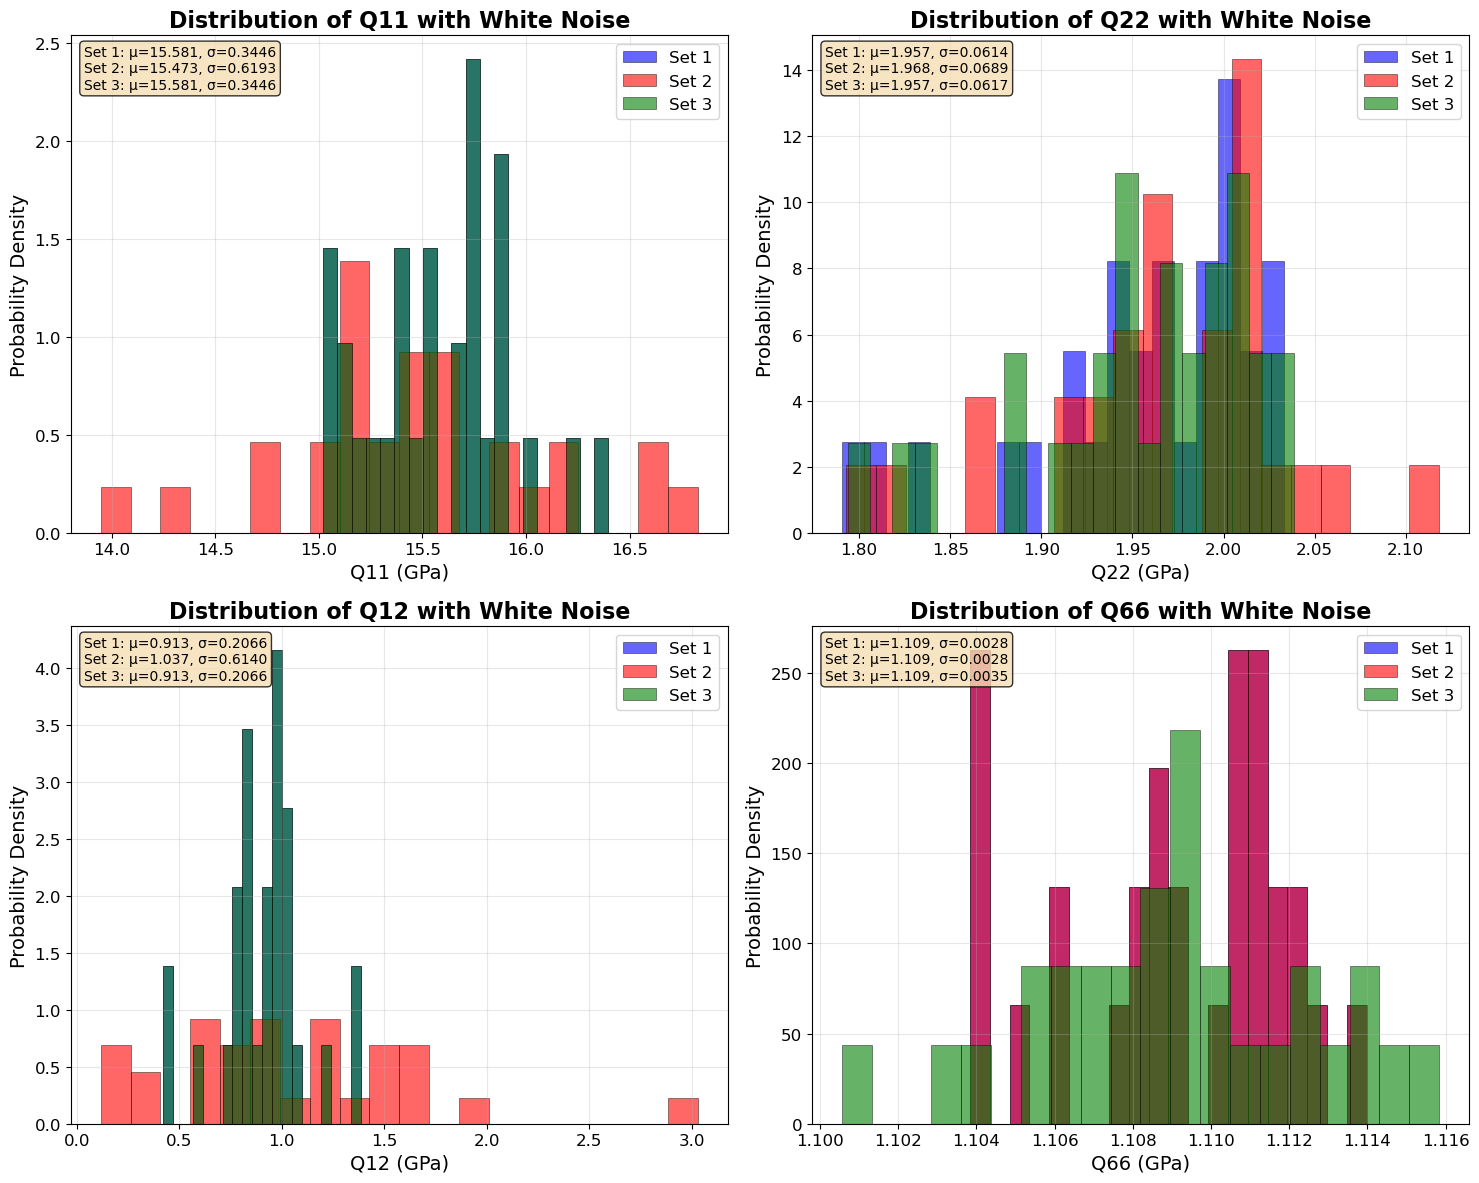


Histogram plots generated successfully!


In [27]:
# Plot histogram results
try:
    vfm_noise.plot_results(save_plots=False)
    print("\nHistogram plots generated successfully!")
except Exception as e:
    print(f"Error plotting results: {e}")

## 8. Visualize Noisy Strain Fields

Display the strain fields with added noise (from last iteration)

Strain field plot saved as 'strain_fields_with_noise.png'


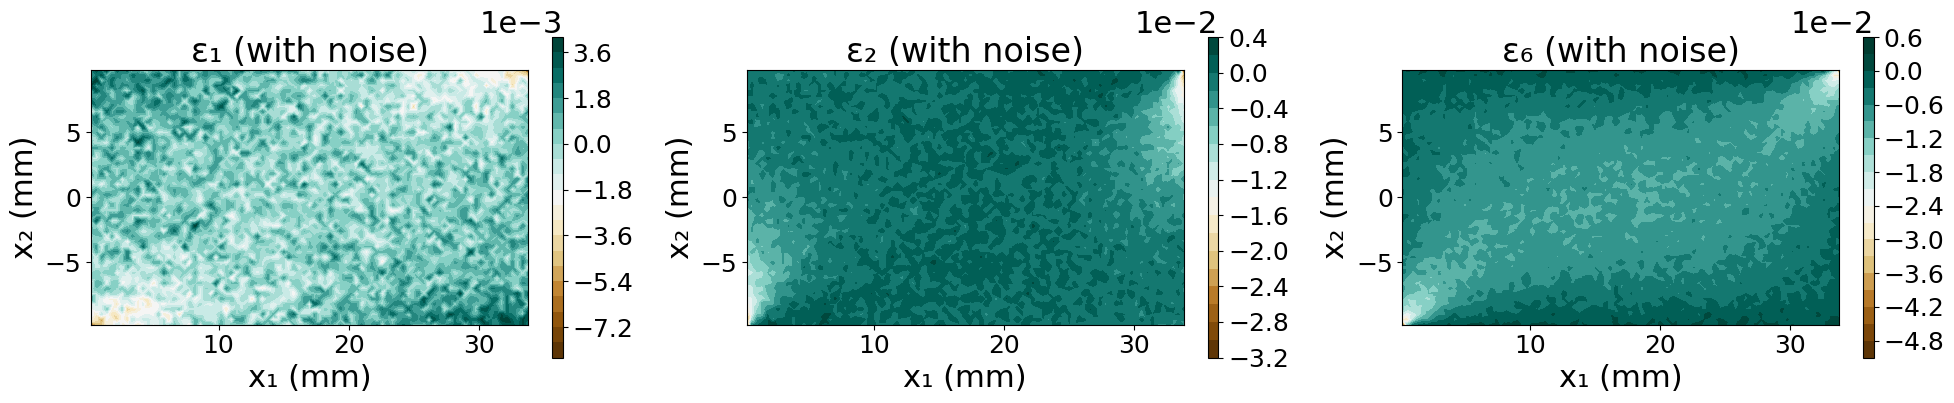


Strain field plots generated successfully!


In [28]:
# Plot strain fields with noise
try:
    vfm_noise.plot_strain_fields()
    print("\nStrain field plots generated successfully!")
except Exception as e:
    print(f"Could not plot strain fields: {e}")

## 9. Summary Statistics

Extract and display key statistics from the noise analysis

In [29]:
# Create summary table
params = ['Q11', 'Q22', 'Q12', 'Q66']
sets = ['set1', 'set2', 'set3']

print("\n" + "=" * 80)
print("NOISE ROBUSTNESS RANKING (by Coefficient of Variation)")
print("=" * 80)

for i, param in enumerate(params):
    print(f"\n{param}:")
    cvs = []
    for set_name in sets:
        values = vfm_noise.noise_results[set_name][param]
        cv = (np.std(values) / np.mean(values)) * 100
        cvs.append((set_name, cv))
    
    # Sort by CV (lower is better)
    cvs.sort(key=lambda x: x[1])
    
    for rank, (set_name, cv) in enumerate(cvs, 1):
        print(f"  {rank}. {set_name}: CV = {cv:.2f}%")


NOISE ROBUSTNESS RANKING (by Coefficient of Variation)

Q11:
  1. set1: CV = 2.21%
  2. set3: CV = 2.21%
  3. set2: CV = 4.00%

Q22:
  1. set1: CV = 3.14%
  2. set3: CV = 3.15%
  3. set2: CV = 3.50%

Q12:
  1. set1: CV = 22.63%
  2. set3: CV = 22.63%
  3. set2: CV = 59.19%

Q66:
  1. set1: CV = 0.25%
  2. set2: CV = 0.25%
  3. set3: CV = 0.31%


## 10. Comparison: Clean vs Noisy Results

In [30]:
# Compare clean and noisy results
if clean_results and noise_results:
    print("\n" + "=" * 80)
    print("COMPARISON: CLEAN vs NOISY DATA (Set 1)")
    print("=" * 80)
    print(f"{'Parameter':<12} {'Clean':<12} {'Noisy (Mean)':<15} {'Noisy (Std)':<15} {'Reference':<12}")
    print("-" * 80)
    
    for i, param in enumerate(params):
        clean_val = clean_results['set1'][i]
        noisy_mean = np.mean(noise_results['set1'][param])
        noisy_std = np.std(noise_results['set1'][param])
        ref_val = Q_ref[i]
        
        print(f"{param:<12} {clean_val:<12.3f} {noisy_mean:<15.3f} {noisy_std:<15.4f} {ref_val:<12.3f}")


COMPARISON: CLEAN vs NOISY DATA (Set 1)
Parameter    Clean        Noisy (Mean)    Noisy (Std)     Reference   
--------------------------------------------------------------------------------
Q11          15.544       15.581          0.3446          15.536      
Q22          1.959        1.957           0.0614          1.965       
Q12          0.924        0.913           0.2066          0.926       
Q66          1.109        1.109           0.0028          1.109       


## Conclusions

### Key Findings from Noise Analysis:

1. **Most Robust Parameters:**
   - $Q_{66}$ (shear stiffness) shows highest robustness with CV typically < 1%
   - Direct measurement from shear-dominated test

2. **Moderately Robust:**
   - $Q_{11}$ with CV around 2-3%
   - $Q_{22}$ with CV around 2-3%

3. **Most Sensitive:**
   - $Q_{12}$ shows highest noise sensitivity
   - Coupling effects are more challenging to separate

4. **Virtual Field Set Comparison:**
   - Sets 1 and 3 show similar robustness
   - Set 2 (cubic through-thickness) shows higher noise sensitivity for $Q_{12}$

### Recommendations:

- Use Set 1 or Set 3 for best noise robustness
- Consider additional tests for accurate $Q_{12}$ identification
- Typical DIC noise levels (10⁻⁴) are acceptable for $Q_{11}$, $Q_{22}$, and $Q_{66}$
- Noise filtering or averaging can improve $Q_{12}$ identification